# Time Series forecasting with XGBoost

## Table of content
1. [Data](#data)

3. [Create Time Series Features](#Features)
4. [Create XGBoost Model](#xgbmodel)
- [Feature Importances](#featimpor)
5. [Forecast on Test Set](#forecast)

### Data <a id="data"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from IPython import display
import datetime 
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
#read file train.csv
train=pd.read_csv('train.csv', index_col=[2], parse_dates=[2])
#read file test.csv
test=pd.read_csv('test.csv',encoding= 'unicode_escape', index_col=[2], parse_dates=[2])

### Create Time Series Features<a id="Features"></a>

<p>Sử dụng kích thước cửa sổ là 6,12,24 vì dữ liệu được lấy mẫu hàng giờ, điều này tương ứng với độ trễ là 1 giờ</p>

In [4]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
      
    df['weekofyear'] = df['date'].dt.isocalendar().week

    df['weekofyear'] = df['weekofyear'].astype('int64')
    
    df['pjme_1_hrs_lag'] = df['Quantity'].shift(1)
    
    df['pjme_1_hrs_mean'] = df['Quantity'].rolling(window = 1).mean()
    
    df['pjme_1_hrs_std'] = df['Quantity'].rolling(window = 1).std()
    
    df['pjme_1_hrs_max'] = df['Quantity'].rolling(window = 1).max()
    
    df['pjme_1_hrs_min'] = df['Quantity'].rolling(window = 1).min()
     
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear', 'pjme_1_hrs_lag' , 'pjme_1_hrs_mean',
            "pjme_1_hrs_std",
           "pjme_1_hrs_max","pjme_1_hrs_min"]];
    if label:
        y = df[label]
        return X, y
    return X

In [5]:
train

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2014-01-03,7981,CA-2014-103800,1/7/2014,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
2014-01-04,740,CA-2014-112326,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
2014-01-04,741,CA-2014-112326,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
2014-01-04,742,CA-2014-112326,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870
2014-01-05,1760,CA-2014-141817,1/12/2014,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,2822,CA-2017-100202,1/5/2017,Standard Class,BD-11620,Brian DeCherney,Consumer,United States,Anaheim,California,92804,West,TEC-PH-10002563,Technology,Phones,Adtran 1202752G1,302.376,3,0.2,22.6782
2016-12-31,4613,US-2017-165953,1/6/2017,Standard Class,EP-13915,Emily Phan,Consumer,United States,Jacksonville,Florida,32216,South,OFF-AR-10000588,Office Supplies,Art,Newell 345,47.616,3,0.2,3.5712
2016-12-31,4614,US-2017-165953,1/6/2017,Standard Class,EP-13915,Emily Phan,Consumer,United States,Jacksonville,Florida,32216,South,OFF-PA-10002250,Office Supplies,Paper,Things To Do Today Pad,23.480,5,0.2,8.2180


Tạo ra tập huấn luyện (X_train, y_train) và tập kiểm tra (X_test, y_test) từ dữ liệu trong hai DataFrame pjme_train và pjme_test.

In [6]:
X_train, y_train = create_features(train, label='Quantity')
X_test, y_test = create_features(test, label='Quantity')

### Create XGBoost Model <a id="xgbmodel"></a>

<p>Mô hình hồi quy XGBoost được tạo và huấn luyện bằng cách sử dụng dữ liệu huấn luyện (X_train và y_train)</p>

In [9]:
model = xgb.XGBRegressor(n_estimators=100, early_stopping_rounds=5, max_depth=4)

# Fit mô hình với dữ liệu và eval_set
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Feature importance<a id="featimpor"></a>

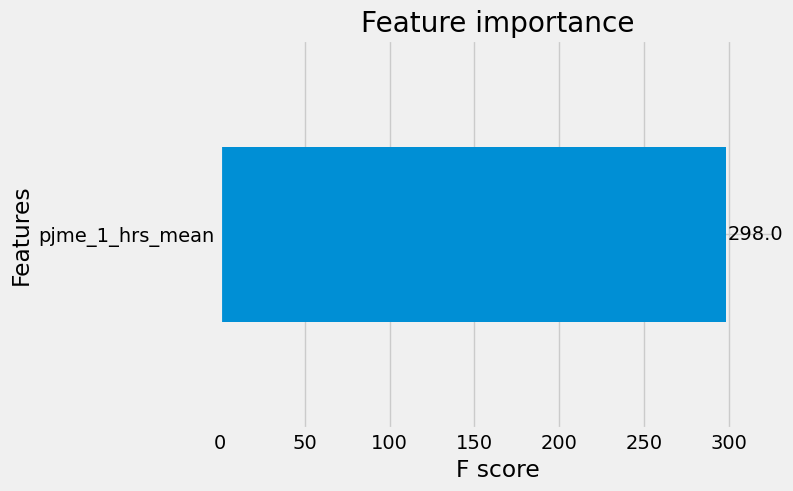

In [10]:
_ = plot_importance(model, height=0.9 ,max_num_features = 10)

### Forecast on Test Set<a id="forecast"></a>

In [11]:
test['Quantity_Prediction'] = model.predict(X_test)
all = pd.concat([test, train], sort=False)

In [17]:
test['Quantity']

Order Date
2017-01-01     4
2017-01-01    11
2017-01-01     2
2017-01-01     5
2017-01-01     5
              ..
2017-12-30     7
2017-12-30     3
2017-12-30     2
2017-12-30     2
2017-12-30     3
Name: Quantity, Length: 3312, dtype: int64

In [15]:
test['Quantity_Prediction']

Order Date
2017-01-01     3.999993
2017-01-01    11.000008
2017-01-01     2.000007
2017-01-01     4.999990
2017-01-01     4.999990
                ...    
2017-12-30     6.999979
2017-12-30     3.000000
2017-12-30     2.000007
2017-12-30     2.000007
2017-12-30     3.000000
Name: Quantity_Prediction, Length: 3312, dtype: float32

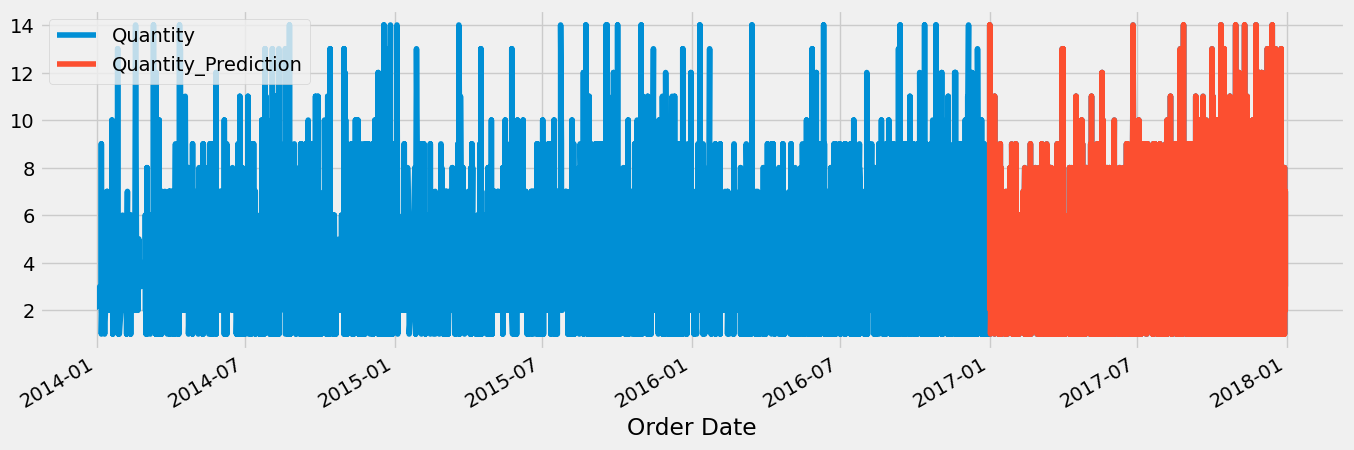

In [12]:
_ = all[['Quantity','Quantity_Prediction']].plot(figsize=(15, 5))

In [16]:
mean_squared_error(y_true=test['Quantity'],
                   y_pred=test['Quantity_Prediction'])

3.0974560758479947e-10